https://zenodo.org/records/3565489#.Y3vFKS-l0eY

In [44]:
# !pip install torch

In [45]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Data Load

In [46]:
# Import the VAE classes from the previous artifact
# (Assumes you've saved it as vae_model.py)


def load_galaxy_data():
    """Your data loading code"""
    image_folder = "/kaggle/input/galaxy-zoo/images/images/"
    mapping_csv = "/kaggle/input/galaxy-zoo/gz2_filename_mapping.csv"
    
    # Load mapping table
    mapping = pd.read_csv(mapping_csv)
    
    # Load images
    images = []
    filenames = []
    
    for f in os.listdir(image_folder):
        if f.lower().endswith(('.png','.jpg','.jpeg')):
            img_path = os.path.join(image_folder, f)
            img = Image.open(img_path).convert('RGB')
            img = img.resize((128,128))
            images.append(np.array(img))
            filenames.append(f)
    
    images = np.array(images)
    print(f"Loaded {len(images)} images")
    
    loaded_filenames_set = set(filenames)
    loaded_filenames_set = [int(f.removesuffix('.jpg')) for f in loaded_filenames_set]
    
    # Read zoo data
    zoo = pd.read_csv("/kaggle/input/galaxy-zoo/zoo/zoo2MainSpecz.csv")
    
    # Rename columns
    zoo = zoo.rename(columns={
        't01_smooth_or_features_a01_smooth_debiased': 'p_smooth',
        't01_smooth_or_features_a02_features_or_disk_debiased': 'p_disk',
        't01_smooth_or_features_a03_star_or_artifact_debiased': 'p_star'
    })
    
    zoo_subset = zoo[['dr7objid', 'p_smooth', 'p_disk', 'p_star']]
    
    # Merge on objid
    df = mapping.merge(zoo_subset, right_on='dr7objid', left_on='objid', how='inner')
    
    # Filter asset_id
    df = df[df['asset_id'].isin(loaded_filenames_set)].copy()
    
    # Create classification columns
    upper_bound = 0.7
    lower_bound = 0.3
    
    df['is_smooth'] = (df['p_smooth'] > upper_bound) & (df['p_disk'] < lower_bound) & (df['p_star'] < lower_bound)
    df['is_disk'] = (df['p_disk'] > upper_bound) & (df['p_smooth'] < lower_bound) & (df['p_star'] < lower_bound)
    # df['is_star'] = (df['p_star'] > upper_bound) & (df['p_smooth'] < lower_bound) & (df['p_disk'] < lower_bound)
    df['check'] = df['is_smooth'] + df['is_disk']
    
    print(f"Number of Smooth: {df['is_smooth'].sum()}")
    print(f"Number of Disk: {df['is_disk'].sum()}")
    # print(f"Number of Star: {df['is_star'].sum()}")
    
    df = df[df['check'] == True]
    print(f"Shape of dataset: {df.shape}")
    
    # Create mapping from filename to index
    filename_to_idx = {f: i for i, f in enumerate(filenames)}
    
    # Get aligned indices
    aligned_indices = []
    for asset_id in df['asset_id'].values:
        fname = f"{asset_id}.jpg"
        if fname in filename_to_idx:
            aligned_indices.append(filename_to_idx[fname])
    
    aligned_images = images[aligned_indices]
    
    print(f"Final aligned dataset: {len(aligned_images)} images")
    
    return aligned_images, df.reset_index(drop=True)



# Data Processing

In [47]:
def normalize_images(images):
    """
    Normalize images to [0, 1] range and standardize
    
    Args:
        images: numpy array of shape (N, H, W, 3) with values in [0, 255]
    
    Returns:
        normalized images in [0, 1]
    """
    # Convert to float and scale to [0, 1]
    images = images.astype(np.float32) / 255.0
    
    print(f"Image statistics after normalization:")
    print(f"  Min: {images.min():.4f}")
    print(f"  Max: {images.max():.4f}")
    print(f"  Mean: {images.mean():.4f}")
    print(f"  Std: {images.std():.4f}")
    
    return images

In [48]:
def compute_dataset_statistics(images):
    """
    Compute mean and std for each channel (for normalization)
    
    Args:
        images: numpy array of shape (N, H, W, 3) in [0, 1]
    
    Returns:
        mean, std per channel
    """
    # Compute per-channel statistics
    mean = images.mean(axis=(0, 1, 2))  # Mean over N, H, W
    std = images.std(axis=(0, 1, 2))
    
    print(f"\nPer-channel statistics:")
    print(f"  Mean (R, G, B): {mean}")
    print(f"  Std (R, G, B): {std}")
    
    return mean, std

# Pytorch Dataset

In [49]:
class GalaxyDataset(Dataset):
    """PyTorch Dataset for galaxy images with proper normalization"""
    
    def __init__(self, images, normalize=True, mean=None, std=None):
        """
        Args:
            images: numpy array of shape (N, H, W, 3) in [0, 255]
            normalize: whether to normalize images
            mean: per-channel mean for normalization (if None, computed from data)
            std: per-channel std for normalization (if None, computed from data)
        """
        # First convert to [0, 1]
        self.images = images.astype(np.float32) / 255.0
        
        # Optional: standardize using mean and std
        if normalize:
            if mean is None or std is None:
                # Compute from data
                self.mean = self.images.mean(axis=(0, 1, 2))
                self.std = self.images.std(axis=(0, 1, 2))
            else:
                self.mean = mean
                self.std = std
            
            # Standardize: (x - mean) / std
            # But we'll keep images in [0,1] for sigmoid output
            # So we just scale to [0, 1] without standardization
            # (Standardization can make training harder with sigmoid)
        
        # Convert to torch tensor and permute to (N, 3, H, W)
        self.images = torch.FloatTensor(self.images).permute(0, 3, 1, 2)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        return self.images[idx]


# VAE

## Encoder

In [50]:
class Encoder(nn.Module):
    """Encoder network: maps image to latent mean and log-variance"""
    
    def __init__(self, latent_dim=16, image_channels=3):
        super(Encoder, self).__init__()
        
        # Convolutional layers
        # Input: (3, 64, 64)
        self.conv1 = nn.Conv2d(image_channels, 32, kernel_size=4, stride=2, padding=1)  # -> (32, 32, 32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)              # -> (64, 16, 16)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)             # -> (128, 8, 8)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)            # -> (256, 4, 4)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        
        # Flatten size: 256 * 4 * 4 = 4096
        self.flatten_size = 256 * 8 * 8
        
        # Dense layers for mean and log-variance
        self.fc_mu = nn.Linear(self.flatten_size, latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_size, latent_dim)
        
    def forward(self, x):
        # Convolutional encoding with ReLU and batch norm
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        
        # Flatten
        x = x.view(-1, self.flatten_size)
        
        # Output mean and log-variance
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        
        return mu, logvar

## Decoder

In [51]:
class Decoder(nn.Module):
    """Decoder network: maps latent vector to reconstructed image"""
    
    def __init__(self, latent_dim=16, image_channels=3):
        super(Decoder, self).__init__()
        
        self.latent_dim = latent_dim
        self.initial_size = 8
        self.initial_channels = 256
        
        # Dense layer to expand latent vector
        self.fc = nn.Linear(latent_dim, self.initial_channels * self.initial_size * self.initial_size)
        
        # Transposed convolutional layers (mirror of encoder)
        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)  # -> (128, 8, 8)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)   # -> (64, 16, 16)
        self.deconv3 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)    # -> (32, 32, 32)
        self.deconv4 = nn.ConvTranspose2d(32, image_channels, kernel_size=4, stride=2, padding=1)  # -> (3, 64, 64)
        
        self.bn1 = nn.BatchNorm2d(128)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(32)
        
    def forward(self, z):
        # Expand and reshape
        x = self.fc(z)
        x = x.view(-1, self.initial_channels, self.initial_size, self.initial_size)
        
        # Transposed convolutions with ReLU and batch norm
        x = F.relu(self.bn1(self.deconv1(x)))
        x = F.relu(self.bn2(self.deconv2(x)))
        x = F.relu(self.bn3(self.deconv3(x)))
        x = torch.sigmoid(self.deconv4(x))  # Output in [0, 1]
        
        return x

## VAE

In [52]:
class VAE(nn.Module):
    """Complete Variational Autoencoder"""
    
    def __init__(self, latent_dim=16, image_channels=3):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        
        self.encoder = Encoder(latent_dim, image_channels)
        self.decoder = Decoder(latent_dim, image_channels)
        
    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick (Eq. 4 in proposal):
        z = mu + sigma * epsilon, where epsilon ~ N(0, I)
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + std * eps
        return z
    
    def forward(self, x):
        # Encode
        mu, logvar = self.encoder(x)
        
        # Reparameterize
        z = self.reparameterize(mu, logvar)
        
        # Decode
        recon_x = self.decoder(z)
        
        return recon_x, mu, logvar
    
    def encode(self, x):
        """Get latent representation (deterministic, for Stage 2)"""
        mu, logvar = self.encoder(x)
        return mu

## LOSS Function

In [53]:
def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    """
    VAE loss = Reconstruction loss + beta * KL divergence
    
    Implements Eq. 5 and 6 from the proposal:
    - Reconstruction: MSE between input and reconstruction
    - KL: Closed-form KL divergence (Eq. 6)
    
    Args:
        recon_x: reconstructed images
        x: original images
        mu: latent mean
        logvar: latent log-variance
        beta: weight for KL term (1.0 for standard VAE)
    
    Returns:
        total_loss, recon_loss, kl_loss
    """
    # Reconstruction loss (MSE)
    recon_loss = F.mse_loss(recon_x, x, reduction='sum') / x.size(0)
    
    # KL divergence (Eq. 6): 0.5 * sum(mu^2 + sigma^2 - log(sigma^2) - 1)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    
    # Total loss
    total_loss = recon_loss + beta * kl_loss
    
    return total_loss, recon_loss, kl_loss

## Training Loop

In [54]:
def train_vae(model, train_loader, val_loader, epochs=100, lr=1e-3, beta=1.0, device='cuda'):
    """
    Train the VAE
    
    Args:
        model: VAE model
        train_loader: training data loader
        val_loader: validation data loader
        epochs: number of training epochs
        lr: learning rate
        beta: KL weight
        device: 'cuda' or 'cpu'
    """
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        # ====================================================================
        # TRAINING
        # ====================================================================
        model.train()
        train_loss = 0
        train_recon = 0
        train_kl = 0
        
        for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]'):
            batch = batch.to(device)
            
            optimizer.zero_grad()
            
            # Forward pass
            recon_batch, mu, logvar = model(batch)
            
            # Compute loss
            loss, recon, kl = vae_loss(recon_batch, batch, mu, logvar, beta)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_recon += recon.item()
            train_kl += kl.item()
        
        train_loss /= len(train_loader)
        train_recon /= len(train_loader)
        train_kl /= len(train_loader)
        train_losses.append(train_loss)
        
        # ====================================================================
        # VALIDATION
        # ====================================================================
        model.eval()
        val_loss = 0
        val_recon = 0
        val_kl = 0
        
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                
                recon_batch, mu, logvar = model(batch)
                loss, recon, kl = vae_loss(recon_batch, batch, mu, logvar, beta)
                
                val_loss += loss.item()
                val_recon += recon.item()
                val_kl += kl.item()
        
        val_loss /= len(val_loader)
        val_recon /= len(val_loader)
        val_kl /= len(val_loader)
        val_losses.append(val_loss)
        
        # Print progress
        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'  Train Loss = {train_loss:.4f} (Recon: {train_recon:.4f}, KL: {train_kl:.4f})')
        print(f'  Val Loss   = {val_loss:.4f} (Recon: {val_recon:.4f}, KL: {val_kl:.4f})')
    
    return train_losses, val_losses


## Visualize

In [55]:
def visualize_reconstructions(model, data_loader, n_samples=10, device='cuda'):
    """Visualize original vs reconstructed images"""
    model.eval()
    
    # Get a batch
    batch = next(iter(data_loader))
    batch = batch[:n_samples].to(device)
    
    with torch.no_grad():
        recon_batch, _, _ = model(batch)
    
    # Move to CPU and convert to numpy
    originals = batch.cpu().permute(0, 2, 3, 1).numpy()
    reconstructions = recon_batch.cpu().permute(0, 2, 3, 1).numpy()
    
    # Plot
    fig, axes = plt.subplots(2, n_samples, figsize=(n_samples*2, 4))
    for i in range(n_samples):
        axes[0, i].imshow(originals[i])
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title('Original', fontsize=10)
        
        axes[1, i].imshow(reconstructions[i])
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title('Reconstructed', fontsize=10)
    
    plt.tight_layout()
    plt.savefig('vae_reconstructions.png', dpi=150, bbox_inches='tight')
    print("Saved reconstruction visualization to: vae_reconstructions.png")
    plt.show()

In [56]:
def plot_training_curves(train_losses, val_losses):
    """Plot training and validation loss curves"""
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss', linewidth=2)
    plt.plot(val_losses, label='Validation Loss', linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('VAE Training Curves', fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
    print("Saved training curves to: training_curves.png")
    plt.show()

In [57]:
def extract_latent_representations(model, data_loader, device='cuda'):
    """
    Extract latent representations for all images (needed for Stage 2: GMM)
    
    Returns:
        latent_vectors: numpy array of shape (N, latent_dim)
    """
    model.eval()
    latent_vectors = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc='Extracting latent representations'):
            batch = batch.to(device)
            
            # Get latent mean (deterministic encoding)
            mu, _ = model.encoder(batch)
            latent_vectors.append(mu.cpu().numpy())
    
    latent_vectors = np.concatenate(latent_vectors, axis=0)
    return latent_vectors

# MAIN

GALAXY MORPHOLOGY VAE TRAINING

Using device: cuda

STEP 1: Loading Galaxy Data
Loaded 14060 images
Number of Smooth: 2696
Number of Disk: 4808
Shape of dataset: (7504, 10)
Final aligned dataset: 7504 images

STEP 2: Normalizing Data
Image statistics after normalization:
  Min: 0.0000
  Max: 1.0000
  Mean: 0.0382
  Std: 0.0756

Per-channel statistics:
  Mean (R, G, B): [0.02985774 0.02512361 0.0202211 ]
  Std (R, G, B): [0.08586708 0.071376   0.06210109]

STEP 3: Splitting Data
Training set: 6003 images
Validation set: 1501 images

Training class distribution:
  Smooth: 2157
  Disk: 3846
  Star: 0

STEP 4: Creating PyTorch Datasets
Train batches: 94
Val batches: 24

STEP 5: Initializing VAE Model
Latent dimension: 16
Total parameters: 2,184,291
Trainable parameters: 2,184,291

STEP 6: Training VAE
Epochs: 100
Learning rate: 0.001
Beta (KL weight): 1.0


Epoch 1/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.50it/s]


Epoch 1/100:
  Train Loss = 1740.4242 (Recon: 1719.4801, KL: 20.9441)
  Val Loss   = 194.7082 (Recon: 184.9083, KL: 9.8000)


Epoch 2/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.93it/s]


Epoch 2/100:
  Train Loss = 140.1275 (Recon: 130.2633, KL: 9.8642)
  Val Loss   = 119.1940 (Recon: 107.9826, KL: 11.2115)


Epoch 3/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.75it/s]


Epoch 3/100:
  Train Loss = 106.1403 (Recon: 95.8212, KL: 10.3191)
  Val Loss   = 101.6255 (Recon: 90.4566, KL: 11.1689)


Epoch 4/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.88it/s]


Epoch 4/100:
  Train Loss = 95.5001 (Recon: 85.1473, KL: 10.3528)
  Val Loss   = 101.2646 (Recon: 86.5538, KL: 14.7108)


Epoch 5/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.76it/s]


Epoch 5/100:
  Train Loss = 90.2281 (Recon: 79.8511, KL: 10.3770)
  Val Loss   = 94.4335 (Recon: 82.5594, KL: 11.8741)


Epoch 6/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.84it/s]


Epoch 6/100:
  Train Loss = 87.0112 (Recon: 76.5859, KL: 10.4253)
  Val Loss   = 90.7814 (Recon: 80.6398, KL: 10.1416)


Epoch 7/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.87it/s]


Epoch 7/100:
  Train Loss = 84.4490 (Recon: 74.0849, KL: 10.3640)
  Val Loss   = 93.9944 (Recon: 85.3483, KL: 8.6461)


Epoch 8/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.88it/s]


Epoch 8/100:
  Train Loss = 82.3678 (Recon: 71.9239, KL: 10.4439)
  Val Loss   = 86.7385 (Recon: 75.9266, KL: 10.8119)


Epoch 9/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.81it/s]


Epoch 9/100:
  Train Loss = 80.7068 (Recon: 70.2175, KL: 10.4893)
  Val Loss   = 86.4448 (Recon: 73.9718, KL: 12.4730)


Epoch 10/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.90it/s]


Epoch 10/100:
  Train Loss = 79.7419 (Recon: 68.9317, KL: 10.8103)
  Val Loss   = 86.3507 (Recon: 74.9097, KL: 11.4410)


Epoch 11/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.91it/s]


Epoch 11/100:
  Train Loss = 78.9786 (Recon: 68.1408, KL: 10.8377)
  Val Loss   = 84.7488 (Recon: 72.9702, KL: 11.7785)


Epoch 12/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.88it/s]


Epoch 12/100:
  Train Loss = 78.0464 (Recon: 67.0279, KL: 11.0185)
  Val Loss   = 83.3729 (Recon: 72.2319, KL: 11.1411)


Epoch 13/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.90it/s]


Epoch 13/100:
  Train Loss = 76.7186 (Recon: 65.7340, KL: 10.9846)
  Val Loss   = 82.5984 (Recon: 71.1914, KL: 11.4070)


Epoch 14/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.86it/s]


Epoch 14/100:
  Train Loss = 76.4618 (Recon: 65.4740, KL: 10.9878)
  Val Loss   = 83.5187 (Recon: 72.2323, KL: 11.2864)


Epoch 15/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.68it/s]


Epoch 15/100:
  Train Loss = 75.4302 (Recon: 64.2837, KL: 11.1465)
  Val Loss   = 82.9551 (Recon: 71.9393, KL: 11.0158)


Epoch 16/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.85it/s]


Epoch 16/100:
  Train Loss = 74.8984 (Recon: 63.6518, KL: 11.2467)
  Val Loss   = 81.5575 (Recon: 69.5835, KL: 11.9739)


Epoch 17/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.70it/s]


Epoch 17/100:
  Train Loss = 74.1941 (Recon: 62.8864, KL: 11.3077)
  Val Loss   = 80.9892 (Recon: 69.3628, KL: 11.6264)


Epoch 18/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.81it/s]


Epoch 18/100:
  Train Loss = 73.3605 (Recon: 62.0165, KL: 11.3440)
  Val Loss   = 80.7212 (Recon: 69.0685, KL: 11.6527)


Epoch 19/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.86it/s]


Epoch 19/100:
  Train Loss = 72.7966 (Recon: 61.2688, KL: 11.5279)
  Val Loss   = 82.5080 (Recon: 70.1163, KL: 12.3917)


Epoch 20/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.88it/s]


Epoch 20/100:
  Train Loss = 72.3706 (Recon: 60.9519, KL: 11.4187)
  Val Loss   = 81.4198 (Recon: 70.3140, KL: 11.1058)


Epoch 21/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.76it/s]


Epoch 21/100:
  Train Loss = 71.9129 (Recon: 60.3378, KL: 11.5751)
  Val Loss   = 79.9759 (Recon: 68.1151, KL: 11.8608)


Epoch 22/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.89it/s]


Epoch 22/100:
  Train Loss = 71.3659 (Recon: 59.7809, KL: 11.5849)
  Val Loss   = 79.6896 (Recon: 68.2229, KL: 11.4668)


Epoch 23/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.95it/s]


Epoch 23/100:
  Train Loss = 71.1058 (Recon: 59.4140, KL: 11.6919)
  Val Loss   = 78.4971 (Recon: 66.7974, KL: 11.6998)


Epoch 24/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.67it/s]


Epoch 24/100:
  Train Loss = 69.8583 (Recon: 58.0456, KL: 11.8127)
  Val Loss   = 78.5225 (Recon: 67.0900, KL: 11.4325)


Epoch 25/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.93it/s]


Epoch 25/100:
  Train Loss = 69.6803 (Recon: 57.6629, KL: 12.0173)
  Val Loss   = 79.0103 (Recon: 67.8206, KL: 11.1897)


Epoch 26/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.80it/s]


Epoch 26/100:
  Train Loss = 69.1699 (Recon: 57.3200, KL: 11.8499)
  Val Loss   = 78.1895 (Recon: 66.7053, KL: 11.4842)


Epoch 27/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.81it/s]


Epoch 27/100:
  Train Loss = 68.5226 (Recon: 56.5825, KL: 11.9401)
  Val Loss   = 78.6456 (Recon: 67.8234, KL: 10.8222)


Epoch 28/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.93it/s]


Epoch 28/100:
  Train Loss = 67.9467 (Recon: 55.8901, KL: 12.0566)
  Val Loss   = 77.1599 (Recon: 64.6729, KL: 12.4870)


Epoch 29/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.95it/s]


Epoch 29/100:
  Train Loss = 67.3221 (Recon: 55.1887, KL: 12.1334)
  Val Loss   = 78.1174 (Recon: 64.5047, KL: 13.6126)


Epoch 30/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.71it/s]


Epoch 30/100:
  Train Loss = 67.8407 (Recon: 55.7491, KL: 12.0915)
  Val Loss   = 77.2294 (Recon: 64.6061, KL: 12.6233)


Epoch 31/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.69it/s]


Epoch 31/100:
  Train Loss = 67.6645 (Recon: 55.5443, KL: 12.1202)
  Val Loss   = 76.6834 (Recon: 64.4723, KL: 12.2112)


Epoch 32/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.90it/s]


Epoch 32/100:
  Train Loss = 66.8121 (Recon: 54.7147, KL: 12.0974)
  Val Loss   = 77.8018 (Recon: 64.4917, KL: 13.3101)


Epoch 33/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.75it/s]


Epoch 33/100:
  Train Loss = 66.4902 (Recon: 54.2123, KL: 12.2779)
  Val Loss   = 78.3089 (Recon: 64.0639, KL: 14.2451)


Epoch 34/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.89it/s]


Epoch 34/100:
  Train Loss = 66.5648 (Recon: 54.2418, KL: 12.3230)
  Val Loss   = 77.4977 (Recon: 64.9031, KL: 12.5946)


Epoch 35/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.87it/s]


Epoch 35/100:
  Train Loss = 66.1093 (Recon: 53.8348, KL: 12.2745)
  Val Loss   = 76.4372 (Recon: 63.9512, KL: 12.4860)


Epoch 36/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.77it/s]


Epoch 36/100:
  Train Loss = 65.7567 (Recon: 53.4096, KL: 12.3470)
  Val Loss   = 76.9431 (Recon: 62.8241, KL: 14.1190)


Epoch 37/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.87it/s]


Epoch 37/100:
  Train Loss = 65.5678 (Recon: 53.1368, KL: 12.4310)
  Val Loss   = 76.8717 (Recon: 63.4320, KL: 13.4397)


Epoch 38/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.89it/s]


Epoch 38/100:
  Train Loss = 65.4778 (Recon: 53.1116, KL: 12.3662)
  Val Loss   = 76.3564 (Recon: 63.0120, KL: 13.3443)


Epoch 39/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.78it/s]


Epoch 39/100:
  Train Loss = 64.7131 (Recon: 52.3345, KL: 12.3787)
  Val Loss   = 76.9368 (Recon: 64.8898, KL: 12.0470)


Epoch 40/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.43it/s]


Epoch 40/100:
  Train Loss = 64.8982 (Recon: 52.3573, KL: 12.5410)
  Val Loss   = 75.9249 (Recon: 63.3924, KL: 12.5326)


Epoch 41/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.85it/s]


Epoch 41/100:
  Train Loss = 64.5583 (Recon: 52.0411, KL: 12.5173)
  Val Loss   = 76.4350 (Recon: 63.7865, KL: 12.6485)


Epoch 42/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.86it/s]


Epoch 42/100:
  Train Loss = 63.9850 (Recon: 51.4982, KL: 12.4868)
  Val Loss   = 76.6478 (Recon: 63.9996, KL: 12.6483)


Epoch 43/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.97it/s]


Epoch 43/100:
  Train Loss = 64.6497 (Recon: 52.1323, KL: 12.5173)
  Val Loss   = 76.7557 (Recon: 63.8412, KL: 12.9145)


Epoch 44/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.85it/s]


Epoch 44/100:
  Train Loss = 64.5015 (Recon: 51.8343, KL: 12.6672)
  Val Loss   = 77.7959 (Recon: 64.7638, KL: 13.0321)


Epoch 45/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.78it/s]


Epoch 45/100:
  Train Loss = 64.3298 (Recon: 51.7213, KL: 12.6085)
  Val Loss   = 76.3272 (Recon: 63.1846, KL: 13.1426)


Epoch 46/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.81it/s]


Epoch 46/100:
  Train Loss = 63.9056 (Recon: 51.1976, KL: 12.7081)
  Val Loss   = 77.1567 (Recon: 63.7178, KL: 13.4388)


Epoch 47/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.89it/s]


Epoch 47/100:
  Train Loss = 63.1898 (Recon: 50.5257, KL: 12.6641)
  Val Loss   = 75.6032 (Recon: 62.9566, KL: 12.6466)


Epoch 48/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.80it/s]


Epoch 48/100:
  Train Loss = 63.2910 (Recon: 50.5290, KL: 12.7620)
  Val Loss   = 76.4717 (Recon: 63.4846, KL: 12.9871)


Epoch 49/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.90it/s]


Epoch 49/100:
  Train Loss = 63.4477 (Recon: 50.6660, KL: 12.7817)
  Val Loss   = 76.2070 (Recon: 63.0969, KL: 13.1101)


Epoch 50/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.84it/s]


Epoch 50/100:
  Train Loss = 63.2411 (Recon: 50.5449, KL: 12.6962)
  Val Loss   = 77.7550 (Recon: 65.1569, KL: 12.5980)


Epoch 51/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.86it/s]


Epoch 51/100:
  Train Loss = 62.7837 (Recon: 50.0839, KL: 12.6998)
  Val Loss   = 75.6605 (Recon: 62.6824, KL: 12.9781)


Epoch 52/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.88it/s]


Epoch 52/100:
  Train Loss = 62.6222 (Recon: 49.8223, KL: 12.7999)
  Val Loss   = 76.6089 (Recon: 63.6379, KL: 12.9710)


Epoch 53/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.88it/s]


Epoch 53/100:
  Train Loss = 62.4540 (Recon: 49.8546, KL: 12.5994)
  Val Loss   = 76.7842 (Recon: 64.5776, KL: 12.2066)


Epoch 54/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.84it/s]


Epoch 54/100:
  Train Loss = 62.4853 (Recon: 49.7386, KL: 12.7467)
  Val Loss   = 76.4139 (Recon: 64.0163, KL: 12.3976)


Epoch 55/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.91it/s]


Epoch 55/100:
  Train Loss = 62.4219 (Recon: 49.6975, KL: 12.7245)
  Val Loss   = 76.1780 (Recon: 63.1183, KL: 13.0597)


Epoch 56/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.70it/s]


Epoch 56/100:
  Train Loss = 61.8449 (Recon: 49.0372, KL: 12.8077)
  Val Loss   = 76.9315 (Recon: 64.6899, KL: 12.2416)


Epoch 57/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.92it/s]


Epoch 57/100:
  Train Loss = 61.7180 (Recon: 48.8284, KL: 12.8896)
  Val Loss   = 76.8763 (Recon: 63.2956, KL: 13.5807)


Epoch 58/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.87it/s]


Epoch 58/100:
  Train Loss = 61.8888 (Recon: 49.0022, KL: 12.8866)
  Val Loss   = 76.7943 (Recon: 63.7244, KL: 13.0698)


Epoch 59/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.84it/s]


Epoch 59/100:
  Train Loss = 61.7200 (Recon: 48.7991, KL: 12.9209)
  Val Loss   = 76.6316 (Recon: 63.5668, KL: 13.0648)


Epoch 60/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 31.00it/s]


Epoch 60/100:
  Train Loss = 61.4535 (Recon: 48.5950, KL: 12.8585)
  Val Loss   = 76.2470 (Recon: 63.0534, KL: 13.1936)


Epoch 61/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.93it/s]


Epoch 61/100:
  Train Loss = 61.1772 (Recon: 48.3115, KL: 12.8656)
  Val Loss   = 77.3459 (Recon: 63.0435, KL: 14.3024)


Epoch 62/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.76it/s]


Epoch 62/100:
  Train Loss = 61.9489 (Recon: 48.9424, KL: 13.0065)
  Val Loss   = 76.3942 (Recon: 62.9735, KL: 13.4206)


Epoch 63/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.87it/s]


Epoch 63/100:
  Train Loss = 61.4477 (Recon: 48.4859, KL: 12.9618)
  Val Loss   = 76.3804 (Recon: 63.9198, KL: 12.4606)


Epoch 64/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.78it/s]


Epoch 64/100:
  Train Loss = 61.1062 (Recon: 48.0969, KL: 13.0093)
  Val Loss   = 76.7394 (Recon: 63.5617, KL: 13.1776)


Epoch 65/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.81it/s]


Epoch 65/100:
  Train Loss = 61.1262 (Recon: 48.1341, KL: 12.9922)
  Val Loss   = 76.2947 (Recon: 63.3999, KL: 12.8947)


Epoch 66/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.96it/s]


Epoch 66/100:
  Train Loss = 60.9363 (Recon: 47.9416, KL: 12.9947)
  Val Loss   = 77.1195 (Recon: 63.4314, KL: 13.6881)


Epoch 67/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.95it/s]


Epoch 67/100:
  Train Loss = 60.8065 (Recon: 47.8214, KL: 12.9851)
  Val Loss   = 76.7846 (Recon: 63.5899, KL: 13.1947)


Epoch 68/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.81it/s]


Epoch 68/100:
  Train Loss = 60.4430 (Recon: 47.4429, KL: 13.0001)
  Val Loss   = 77.2001 (Recon: 63.1576, KL: 14.0424)


Epoch 69/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.86it/s]


Epoch 69/100:
  Train Loss = 60.2726 (Recon: 47.2806, KL: 12.9921)
  Val Loss   = 76.5787 (Recon: 63.4523, KL: 13.1265)


Epoch 70/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.91it/s]


Epoch 70/100:
  Train Loss = 60.3767 (Recon: 47.3227, KL: 13.0540)
  Val Loss   = 76.5895 (Recon: 63.1683, KL: 13.4212)


Epoch 71/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.80it/s]


Epoch 71/100:
  Train Loss = 60.3185 (Recon: 47.3181, KL: 13.0004)
  Val Loss   = 76.4173 (Recon: 63.1506, KL: 13.2667)


Epoch 72/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.93it/s]


Epoch 72/100:
  Train Loss = 60.3290 (Recon: 47.2270, KL: 13.1020)
  Val Loss   = 77.7804 (Recon: 64.6632, KL: 13.1172)


Epoch 73/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.91it/s]


Epoch 73/100:
  Train Loss = 60.1144 (Recon: 47.0735, KL: 13.0409)
  Val Loss   = 77.2303 (Recon: 63.7796, KL: 13.4507)


Epoch 74/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.79it/s]


Epoch 74/100:
  Train Loss = 60.0740 (Recon: 47.0886, KL: 12.9853)
  Val Loss   = 76.8084 (Recon: 64.0848, KL: 12.7237)


Epoch 75/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.84it/s]


Epoch 75/100:
  Train Loss = 60.1609 (Recon: 47.1533, KL: 13.0075)
  Val Loss   = 77.3151 (Recon: 63.5171, KL: 13.7980)


Epoch 76/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.82it/s]


Epoch 76/100:
  Train Loss = 59.8408 (Recon: 46.7980, KL: 13.0429)
  Val Loss   = 76.7739 (Recon: 63.2139, KL: 13.5600)


Epoch 77/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.76it/s]


Epoch 77/100:
  Train Loss = 59.6559 (Recon: 46.5151, KL: 13.1408)
  Val Loss   = 76.7403 (Recon: 63.4476, KL: 13.2927)


Epoch 78/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.85it/s]


Epoch 78/100:
  Train Loss = 59.4504 (Recon: 46.4994, KL: 12.9510)
  Val Loss   = 76.3295 (Recon: 63.4411, KL: 12.8884)


Epoch 79/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.84it/s]


Epoch 79/100:
  Train Loss = 60.0572 (Recon: 46.9248, KL: 13.1324)
  Val Loss   = 77.0682 (Recon: 63.7231, KL: 13.3450)


Epoch 80/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.87it/s]


Epoch 80/100:
  Train Loss = 59.8144 (Recon: 46.7408, KL: 13.0736)
  Val Loss   = 76.4880 (Recon: 62.8698, KL: 13.6182)


Epoch 81/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.93it/s]


Epoch 81/100:
  Train Loss = 59.5204 (Recon: 46.3650, KL: 13.1554)
  Val Loss   = 77.3390 (Recon: 64.6084, KL: 12.7306)


Epoch 82/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.96it/s]


Epoch 82/100:
  Train Loss = 59.2002 (Recon: 46.1347, KL: 13.0655)
  Val Loss   = 76.3119 (Recon: 62.9880, KL: 13.3239)


Epoch 83/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.86it/s]


Epoch 83/100:
  Train Loss = 59.2401 (Recon: 46.1449, KL: 13.0952)
  Val Loss   = 77.3469 (Recon: 64.4258, KL: 12.9212)


Epoch 84/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.96it/s]


Epoch 84/100:
  Train Loss = 59.0147 (Recon: 45.9135, KL: 13.1012)
  Val Loss   = 76.6936 (Recon: 63.2871, KL: 13.4065)


Epoch 85/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.87it/s]


Epoch 85/100:
  Train Loss = 59.4128 (Recon: 46.2581, KL: 13.1547)
  Val Loss   = 77.7710 (Recon: 64.9698, KL: 12.8011)


Epoch 86/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.75it/s]


Epoch 86/100:
  Train Loss = 59.0209 (Recon: 45.9562, KL: 13.0647)
  Val Loss   = 76.7343 (Recon: 62.8515, KL: 13.8828)


Epoch 87/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.77it/s]


Epoch 87/100:
  Train Loss = 58.7933 (Recon: 45.6139, KL: 13.1794)
  Val Loss   = 77.1855 (Recon: 63.7957, KL: 13.3897)


Epoch 88/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.77it/s]


Epoch 88/100:
  Train Loss = 58.7493 (Recon: 45.6110, KL: 13.1383)
  Val Loss   = 76.8520 (Recon: 63.6440, KL: 13.2080)


Epoch 89/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.79it/s]


Epoch 89/100:
  Train Loss = 58.6255 (Recon: 45.5479, KL: 13.0775)
  Val Loss   = 76.9705 (Recon: 63.9665, KL: 13.0040)


Epoch 90/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.91it/s]


Epoch 90/100:
  Train Loss = 58.6756 (Recon: 45.5300, KL: 13.1457)
  Val Loss   = 77.4167 (Recon: 64.2575, KL: 13.1592)


Epoch 91/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.80it/s]


Epoch 91/100:
  Train Loss = 58.7785 (Recon: 45.5768, KL: 13.2017)
  Val Loss   = 77.3675 (Recon: 64.2622, KL: 13.1053)


Epoch 92/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.81it/s]


Epoch 92/100:
  Train Loss = 58.5265 (Recon: 45.4320, KL: 13.0945)
  Val Loss   = 77.9716 (Recon: 65.1700, KL: 12.8016)


Epoch 93/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.86it/s]


Epoch 93/100:
  Train Loss = 58.5841 (Recon: 45.2935, KL: 13.2906)
  Val Loss   = 76.5715 (Recon: 63.6151, KL: 12.9564)


Epoch 94/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.87it/s]


Epoch 94/100:
  Train Loss = 58.1373 (Recon: 44.9659, KL: 13.1715)
  Val Loss   = 76.6658 (Recon: 63.9171, KL: 12.7486)


Epoch 95/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.75it/s]


Epoch 95/100:
  Train Loss = 58.9533 (Recon: 45.7812, KL: 13.1721)
  Val Loss   = 77.6360 (Recon: 64.5215, KL: 13.1145)


Epoch 96/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.83it/s]


Epoch 96/100:
  Train Loss = 58.8877 (Recon: 45.6026, KL: 13.2850)
  Val Loss   = 77.1006 (Recon: 63.9594, KL: 13.1411)


Epoch 97/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.83it/s]


Epoch 97/100:
  Train Loss = 58.1012 (Recon: 44.9225, KL: 13.1787)
  Val Loss   = 77.0593 (Recon: 63.8805, KL: 13.1788)


Epoch 98/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.83it/s]


Epoch 98/100:
  Train Loss = 57.9480 (Recon: 44.6973, KL: 13.2507)
  Val Loss   = 77.5422 (Recon: 63.9991, KL: 13.5431)


Epoch 99/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.91it/s]


Epoch 99/100:
  Train Loss = 57.8048 (Recon: 44.6824, KL: 13.1224)
  Val Loss   = 76.9416 (Recon: 63.7400, KL: 13.2016)


Epoch 100/100 [Train]: 100%|██████████| 94/94 [00:03<00:00, 30.84it/s]


Epoch 100/100:
  Train Loss = 58.0341 (Recon: 44.7962, KL: 13.2379)
  Val Loss   = 78.3711 (Recon: 65.0527, KL: 13.3184)

STEP 7: Visualizing Results
Saved training curves to: training_curves.png


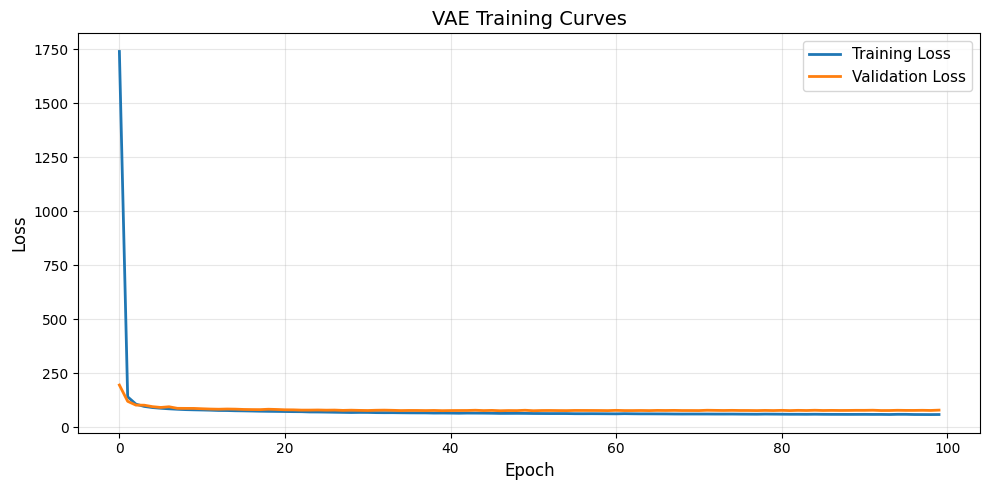

Saved reconstruction visualization to: vae_reconstructions.png


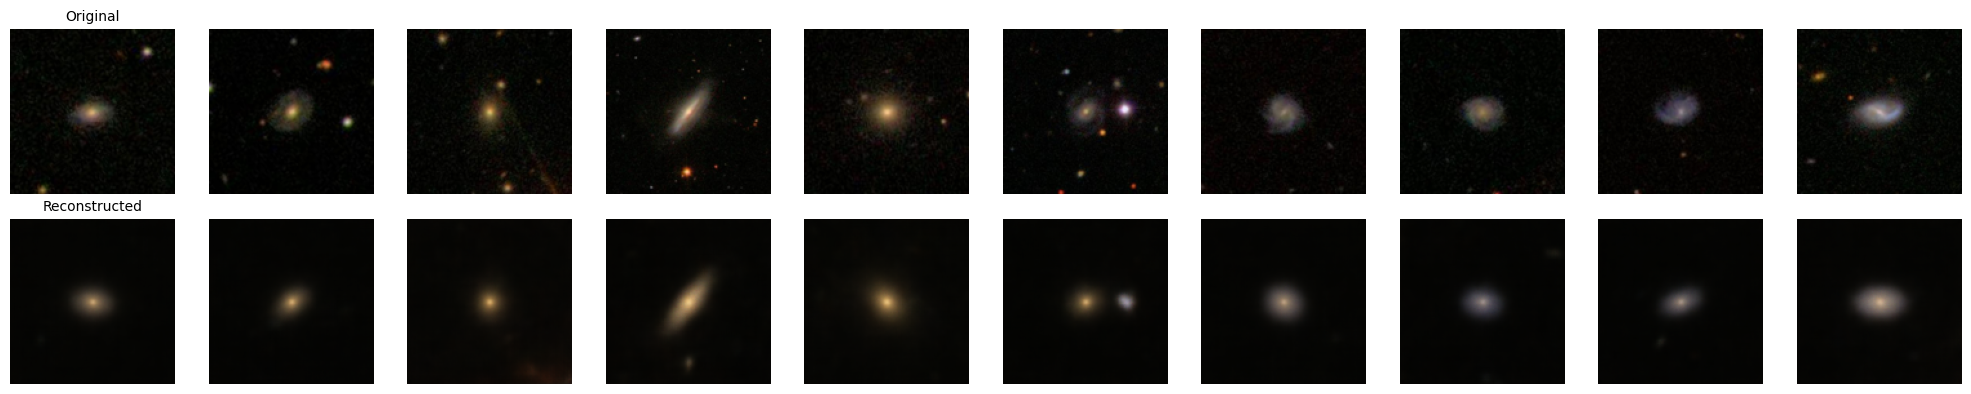


STEP 8: Extracting Latent Representations for GMM


Extracting latent representations: 100%|██████████| 118/118 [00:01<00:00, 112.76it/s]


Latent representations shape: (7504, 16)
Latent statistics:
  Mean: 0.0017
  Std: 0.8505
  Min: -5.4607
  Max: 8.8808

STEP 8: Extracting Latent Representations for GMM


Extracting latent representations: 100%|██████████| 118/118 [00:01<00:00, 112.40it/s]



STEP 8.1: Visualizing Latent Space (t-SNE)
Computing t-SNE visualization...
Saved t-SNE visualization to: latent_space_tsne.png


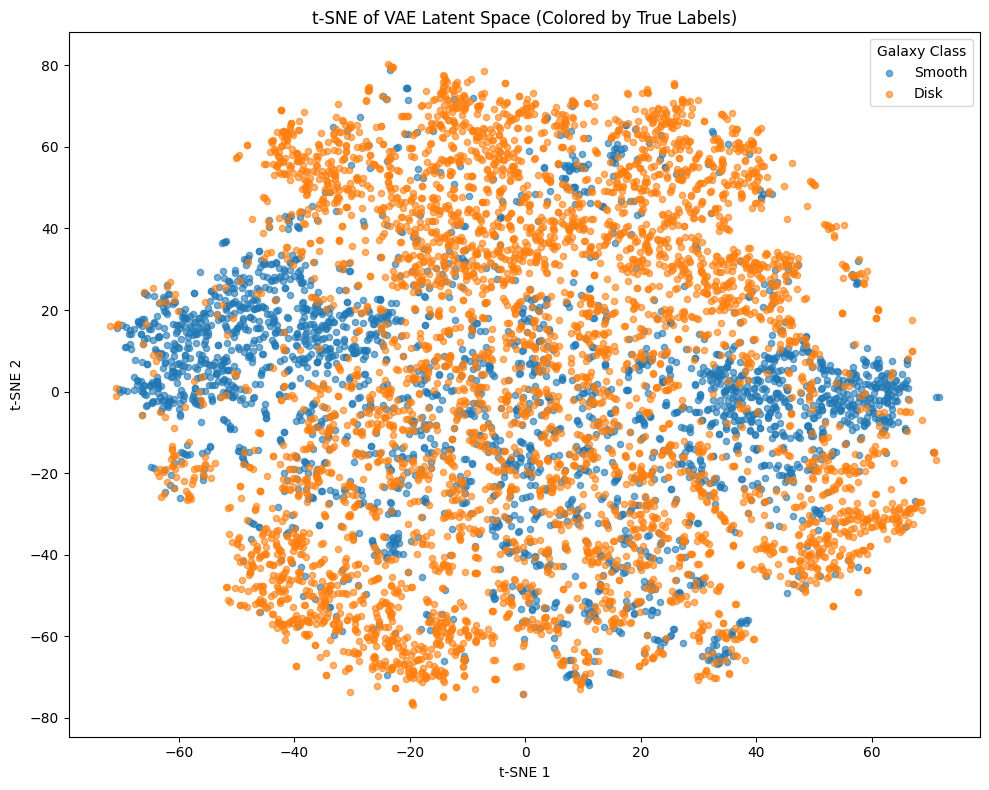


STEP 9: Saving Results
✓ Saved model: vae_galaxy_model.pth
✓ Saved latent vectors: latent_representations.npy
✓ Saved metadata: galaxy_metadata.csv
✓ Saved split indices

VAE TRAINING COMPLETE!

✓ Ready for Stage 2: Bayesian GMM Clustering
  Use 'latent_representations.npy' for clustering


In [58]:
# ============================================================================
# MAIN SCRIPT
# ============================================================================

def main():
    print("="*70)
    print("GALAXY MORPHOLOGY VAE TRAINING")
    print("="*70)
    
    # Set random seeds
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"\nUsing device: {device}")
    
    # ========================================================================
    # STEP 1: LOAD DATA
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 1: Loading Galaxy Data")
    print("="*70)
    
    images, df = load_galaxy_data()
    
    # ========================================================================
    # STEP 2: NORMALIZE DATA
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 2: Normalizing Data")
    print("="*70)
    
    images_normalized = normalize_images(images)
    mean, std = compute_dataset_statistics(images_normalized)
    
    # ========================================================================
    # STEP 3: TRAIN/VAL SPLIT
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 3: Splitting Data")
    print("="*70)
    
    # Create labels for stratification
    labels = df[['is_smooth', 'is_disk']].values.argmax(axis=1)
    
    train_idx, val_idx = train_test_split(
        np.arange(len(images)),
        test_size=0.2,
        random_state=42,
        stratify=labels
    )
    
    # Split images (use original uint8 images, dataset will normalize)
    train_images = images[train_idx]
    val_images = images[val_idx]
    
    print(f"Training set: {len(train_images)} images")
    print(f"Validation set: {len(val_images)} images")
    
    # Print class distribution
    train_labels = labels[train_idx]
    val_labels = labels[val_idx]
    print(f"\nTraining class distribution:")
    print(f"  Smooth: {(train_labels == 0).sum()}")
    print(f"  Disk: {(train_labels == 1).sum()}")
    print(f"  Star: {(train_labels == 2).sum()}")
    
    # ========================================================================
    # STEP 4: CREATE DATASETS
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 4: Creating PyTorch Datasets")
    print("="*70)
    
    train_dataset = GalaxyDataset(train_images, normalize=True)
    val_dataset = GalaxyDataset(val_images, normalize=True)
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=64,
        shuffle=True,
        num_workers=0,
        pin_memory=(device == 'cuda')
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=64,
        shuffle=False,
        num_workers=0,
        pin_memory=(device == 'cuda')
    )
    
    print(f"Train batches: {len(train_loader)}")
    print(f"Val batches: {len(val_loader)}")
    
    # ========================================================================
    # STEP 5: INITIALIZE MODEL
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 5: Initializing VAE Model")
    print("="*70)
    
    latent_dim = 16
    model = VAE(latent_dim=latent_dim, image_channels=3)
    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"Latent dimension: {latent_dim}")
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    # ========================================================================
    # STEP 6: TRAIN MODEL
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 6: Training VAE")
    print("="*70)
    
    epochs = 100
    learning_rate = 1e-3
    beta = 1.0
    
    print(f"Epochs: {epochs}")
    print(f"Learning rate: {learning_rate}")
    print(f"Beta (KL weight): {beta}")
    
    train_losses, val_losses = train_vae(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=epochs,
        lr=learning_rate,
        beta=beta,
        device=device
    )
    
    # ========================================================================
    # STEP 7: VISUALIZE
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 7: Visualizing Results")
    print("="*70)
    
    plot_training_curves(train_losses, val_losses)
    visualize_reconstructions(model, val_loader, n_samples=10, device=device)
    
    # ========================================================================
    # STEP 8: EXTRACT LATENT REPRESENTATIONS
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 8: Extracting Latent Representations for GMM")
    print("="*70)
    
    full_dataset = GalaxyDataset(images, normalize=True)
    full_loader = DataLoader(full_dataset, batch_size=64, shuffle=False, num_workers=0)
    
    latent_vectors = extract_latent_representations(model, full_loader, device=device)
    
    print(f"Latent representations shape: {latent_vectors.shape}")
    print(f"Latent statistics:")
    print(f"  Mean: {latent_vectors.mean():.4f}")
    print(f"  Std: {latent_vectors.std():.4f}")
    print(f"  Min: {latent_vectors.min():.4f}")
    print(f"  Max: {latent_vectors.max():.4f}")

    # ========================================================================
    # STEP 9: EXTRACT LATENT REPRESENTATIONS (Produces latent_vectors)
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 8: Extracting Latent Representations for GMM")
    print("="*70)
    
    # full_loader is created and latent_vectors is computed here...
    latent_vectors = extract_latent_representations(model, full_loader, device=device)
    
    # The variable 'df' (metadata) is available from Step 1/Load
    # The variable 'images' is available from Step 1/Load
    
    # ========================================================================
    # NEW STEP 9.1: VISUALIZE LATENT SPACE (t-SNE)
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 8.1: Visualizing Latent Space (t-SNE)")
    print("="*70)
    
    try:
        from sklearn.manifold import TSNE
        import matplotlib.pyplot as plt
        
        # --- Data Preparation for t-SNE ---
        # 1. Labels are derived from the 'df' DataFrame
        labels = df[['is_smooth', 'is_disk']].values.argmax(axis=1)
        label_names = ['Smooth', 'Disk']
        
        # --- t-SNE Computation ---
        print("Computing t-SNE visualization...")
        tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate='auto', init='random')
        latent_2d = tsne.fit_transform(latent_vectors)
        
        # --- Plotting ---
        plt.figure(figsize=(10, 8))
        for i, name in enumerate(label_names):
            mask = labels == i
            plt.scatter(latent_2d[mask, 0], latent_2d[mask, 1], 
                        label=name, alpha=0.6, s=20)
        
        plt.legend(title='Galaxy Class')
        plt.title('t-SNE of VAE Latent Space (Colored by True Labels)')
        plt.xlabel('t-SNE 1')
        plt.ylabel('t-SNE 2')
        plt.tight_layout()
        plt.savefig('latent_space_tsne.png', dpi=150)
        print("Saved t-SNE visualization to: latent_space_tsne.png")
        plt.show()
        
    except ImportError:
        print("sklearn or matplotlib not available, skipping t-SNE visualization")
    except Exception as e:
        print(f"An error occurred during t-SNE visualization: {e}")

    # ========================================================================
    # STEP 10: SAVE EVERYTHING
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 9: Saving Results")
    print("="*70)
    
    # Save model
    torch.save({
        'epoch': epochs,
        'model_state_dict': model.state_dict(),
        'latent_dim': latent_dim,
        'train_losses': train_losses,
        'val_losses': val_losses,
    }, 'vae_galaxy_model.pth')
    print("✓ Saved model: vae_galaxy_model.pth")
    
    # Save latent representations
    np.save('latent_representations.npy', latent_vectors)
    print("✓ Saved latent vectors: latent_representations.npy")
    
    # Save metadata
    df.to_csv('galaxy_metadata.csv', index=False)
    print("✓ Saved metadata: galaxy_metadata.csv")
    
    # Save splits
    np.save('train_indices.npy', train_idx)
    np.save('val_indices.npy', val_idx)
    print("✓ Saved split indices")
    
    print("\n" + "="*70)
    print("VAE TRAINING COMPLETE!")
    print("="*70)
    print("\n✓ Ready for Stage 2: Bayesian GMM Clustering")
    print("  Use 'latent_representations.npy' for clustering")
    print("="*70)


if __name__ == "__main__":
    main()

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import os 
# NOTE: You will need to load 'df' or the necessary labels/metadata here.

# --- LOAD DATA ---
try:
    # 1. Load the computed latent vectors (from the file saved in your main() function)
    latent_vectors = np.load('latent_representations.npy')
    
    # 2. Load metadata (df) and derive labels (Assuming you saved galaxy_metadata.csv)
    # The actual label derivation logic must be replicated here.
    df = pd.read_csv('galaxy_metadata.csv')
    
    # Assuming 'is_smooth', 'is_disk', 'is_star' columns were present or the equivalent argmax logic:
    all_labels = df[['is_smooth', 'is_disk']].values.argmax(axis=1)
    label_names = ['Smooth', 'Disk']
    
except FileNotFoundError:
    print("Error: Could not find 'latent_representations.npy' or 'galaxy_metadata.csv'.")
    print("Ensure the VAE training was completed and results were saved to disk.")
    exit()

Starting t-SNE on 7504 samples...
t-SNE computation complete.


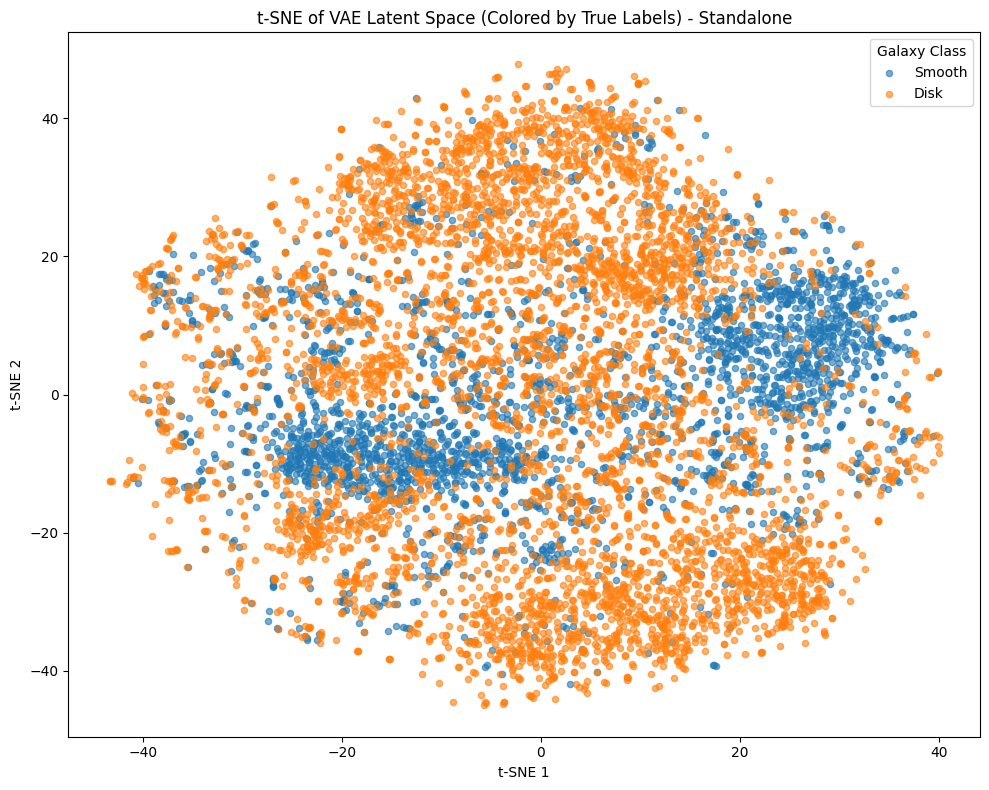

In [60]:
# --- t-SNE COMPUTATION ---
print(f"Starting t-SNE on {latent_vectors.shape[0]} samples...")

# Initialize and fit t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=100, learning_rate='auto', init='random')
latent_2d = tsne.fit_transform(latent_vectors)

print("t-SNE computation complete.")

# --- PLOTTING ---
plt.figure(figsize=(10, 8))
for i, name in enumerate(label_names):
    mask = all_labels == i
    plt.scatter(latent_2d[mask, 0], latent_2d[mask, 1], 
                label=name, alpha=0.6, s=20)

plt.legend(title='Galaxy Class')
plt.title('t-SNE of VAE Latent Space (Colored by True Labels) - Standalone')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.tight_layout()
plt.savefig('latent_space_tsne_standalone.png', dpi=150)
plt.show()